#掛載雲端

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 載入 AOI瑕疵檢測 資料集

In [2]:
#將壓縮檔複製到/content
! cp  "/content/drive/MyDrive/AIdea_AOI/train_images.zip" /content/

In [3]:
#解壓縮訓練集
! unzip /content/train_images > data_unzip.log

replace train_images/train_00000.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train_images/train_00001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [4]:
#read csv
import pandas as pd
AOI_data = pd.read_csv('/content/drive/MyDrive/AIdea_AOI/train.csv')

In [5]:
#查看訓練集每類別圖片數量並且分類
label = []
for i in range(6):
  #請輸入程式碼
  temp = AOI_data[AOI_data['Label']==i]
  label.append(temp.reset_index())
  print('第'+str(i)+'類張數'+str(len(label[i])))

第0類張數674
第1類張數492
第2類張數100
第3類張數378
第4類張數240
第5類張數644


In [6]:
import numpy as np
def add_light(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")

    image=cv2.LUT(image, table)
    return image

In [7]:
def invert_image(image,channel):
    # image=cv2.bitwise_not(image)
    image=(channel-image)
    return image

In [8]:
def flip_image(image,dir):
    image = cv2.flip(image, dir)
    return image

In [10]:
from sys import last_traceback
import cv2
import random 

train_images = []
train_label = []
test_images = []
test_label = []
for i in range(6):
  #讀取圖片測試集圖片(這邊的程式碼不可更動)
  images_temp = []
  label_temp = [i] * 20
  for j in range(20):
    img = cv2.imread('/content/train_images/'+label[i]['ID'][j])
    images_temp.append(cv2.resize(img,(224,224), cv2.INTER_AREA))
  test_images += images_temp
  test_label += label_temp

  #將剩餘圖片進行增量，使訓練集每類張數相同
  #請輸入程式碼
  images_temp = []
  add = []
  label_temp = [i] * 700
  
  for j in range(20, len(label[i])):
    img = cv2.imread('/content/train_images/'+label[i]['ID'][j])
    images_temp.append(cv2.resize(img,(224,224), cv2.INTER_AREA))
  
  count = 0
  last = 700-len(images_temp)

  if (len(images_temp)<last):
    while(len(add)<last):
      k = 0
      while(k < len(images_temp)):
        if (len(add)<last):
          img = cv2.imread('/content/train_images/'+label[i]['ID'][k])
          img = cv2.resize(img,(224,224), cv2.INTER_AREA)
          choice = random.randint(0, 2)
          if (choice == 0):
            added = add_light(img, 1.5)
          elif (choice == 1):
            added = invert_image(img, 150)
          else: 
            added = flip_image(img, 1)#vertical
          add.append(added)
          k+=1
        else:
          break
  else:
    for k in range(0, last):
      img = cv2.imread('/content/train_images/'+label[i]['ID'][k])
      img = cv2.resize(img,(224,224), cv2.INTER_AREA)
      choice = random.randint(0, 2)
      if (choice == 0):
          added = add_light(img, 1.5)
      elif (choice == 1):
          added = invert_image(img, 200)
      else: 
          added = flip_image(img, -1)#vertical
      add.append(added)
  
  #print(len(add))

  train_images += images_temp
  train_images += add
  train_label += label_temp

In [11]:
#將 list 轉成 array
import numpy as np
from sklearn.utils import shuffle
x_train = np.array(train_images)
x_test = np.array(test_images)
y_train = np.array(train_label)
y_test = np.array(test_label)

In [12]:
#將訓練集進行shuffle
import random
#請輸入程式碼
x_train, y_train = shuffle(x_train, y_train, random_state=random.seed())

# 查看資料的 shape

In [13]:
print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)

x_train shape:  (4200, 224, 224, 3)
x_test shape:  (120, 224, 224, 3)


# 查看標籤的 shape

In [14]:
print('y_train shape:',y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (4200,)
y_test shape: (120,)


# 查看標籤的內容 

In [15]:
print(y_train[0:10])

[1 0 1 5 2 3 0 4 0 2]


# 進行 min-max normalization

In [16]:
x_train_norm = x_train.astype('float32')/255
x_test_norm = x_test.astype('float32')/255

In [17]:
print(x_train_norm[0][0][0])

[0.8039216 0.8039216 0.8039216]


# 將數字標籤進行 One-hot 編碼

In [18]:
from tensorflow.keras import utils

# 轉換前
print(y_train[0])

1


In [19]:
# 進行 One-hot 編碼轉換...
y_train_onehot = utils.to_categorical(y_train, 6)
y_test_onehot = utils.to_categorical(y_test, 6)
# 轉換後
print(y_train_onehot[0])

[0. 1. 0. 0. 0. 0.]


# 建立 CNN 神經網路架構

In [20]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

import tensorflow.keras.applications as tensorflow_model

In [21]:
#請輸入參數
vgg16 = tensorflow_model.VGG16(
    include_top=False, 
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='max', classifier_activation='softmax') 

In [22]:
#修改全聯階層的輸出類別數
#請輸入程式碼
num_classes = 6
x = vgg16.layers[-1].output
x = Flatten(name='Flatten')(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation='softmax', name='predictions')(x)

# Create your own model 
cnn = keras.models.Model(inputs = vgg16.input, outputs=x) 
cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [23]:
# 神經網路的訓練配置 #
adam = tf.optimizers.Adam(0.0001)
cnn.compile(optimizer = adam,loss = 'categorical_crossentropy', metrics = ['acc'])

In [25]:
# 進行訓練 #
history = cnn.fit(x=x_train_norm,y=y_train_onehot,batch_size=32,epochs=20,validation_split=0.2)

Epoch 1/20
105/105 [==============================] - 52s 484ms/step - loss: 0.8986 - acc: 0.6786 - val_loss: 0.6524 - val_acc: 0.7071
Epoch 2/20
105/105 [==============================] - 49s 463ms/step - loss: 0.6076 - acc: 0.7643 - val_loss: 0.4157 - val_acc: 0.8464
Epoch 3/20
105/105 [==============================] - 49s 471ms/step - loss: 0.4858 - acc: 0.8241 - val_loss: 0.3187 - val_acc: 0.8833
Epoch 4/20
105/105 [==============================] - 50s 478ms/step - loss: 0.4067 - acc: 0.8506 - val_loss: 0.2703 - val_acc: 0.8940
Epoch 5/20
105/105 [==============================] - 51s 486ms/step - loss: 0.3507 - acc: 0.8676 - val_loss: 0.3064 - val_acc: 0.8929
Epoch 6/20
105/105 [==============================] - 51s 488ms/step - loss: 0.3386 - acc: 0.8789 - val_loss: 0.2544 - val_acc: 0.9190
Epoch 7/20
105/105 [==============================] - 51s 487ms/step - loss: 0.2892 - acc: 0.8961 - val_loss: 0.2126 - val_acc: 0.9250
Epoch 8/20
105/105 [==============================] - 5

In [26]:
import matplotlib.pyplot as plt
def show_train_history(train_history, train, validation, label):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.legend(['Train', 'validation'], loc='upper left')
    plt.show()

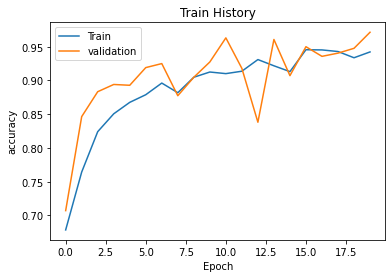

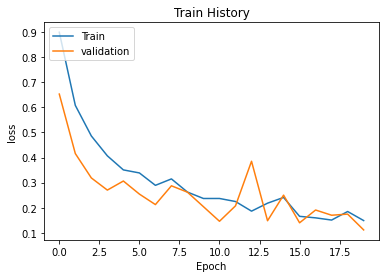

In [27]:
show_train_history(history, 'acc', 'val_acc', 'accuracy')
show_train_history(history, 'loss', 'val_loss', 'loss')

# 使用測試資料評估神經網路

In [28]:
# evaluate
test_loss,test_val = cnn.evaluate(x_test_norm,y_test_onehot)
print('測試資料損失值:', test_loss)
print('測試資料準確度:', test_val)

4/4 [==============================] - 3s 864ms/step - loss: 0.1483 - acc: 0.9417
測試資料損失值: 0.14829175174236298
測試資料準確度: 0.9416666626930237


In [ ]:
# predict
predict_prop = cnn.predict(x_test_norm)
print('第一筆測試資料的預測機率', predict_prop[0])

第一筆測試資料的預測機率 [5.3620076e-01 9.1038318e-03 3.1686342e-01 1.3646436e-01 1.3534890e-03
 1.4220403e-05]


# 將模型轉換成ONNX

In [ ]:
#安裝套件 tf2onnx
!pip install tf-estimator-nightly==2.8.0.dev2021122109 #colab環境缺少此套件 需安裝此套件才能完整安裝tf2onnx
!pip install git+https://github.com/onnx/tensorflow-onnx

In [ ]:
#進行轉換
import tf2onnx
#請輸入程式碼


In [ ]:
#檢查opset版本
#請輸入程式碼


In [ ]:
#由於耐能的量化過程只支持opset ai.onnx 所以移除ai.onnx.ml並儲存
#請輸入程式碼
